# 03: 損失関数 (Loss Functions)

このノートブックでは、ニューラルネットワークの学習における「羅針盤」の役割を果たす「損失関数」について深く学びます。損失関数は、モデルの予測がどれだけ真の値から外れているかを測る指標であり、この値を最小化することが学習の目的となります。

分類タスクと回帰タスク、それぞれの代表的な損失関数を取り上げ、その数式的な定義、特性、そしてなぜそのタスクに適しているのかを解説します。

**参考論文:**
*   (Label Smoothing) Szegedy, C., et al. (2016). Rethinking the Inception Architecture for Computer Vision.
*   (Focal Loss) Lin, T. Y., et al. (2017). Focal Loss for Dense Object Detection.
*   (Huber Loss) Huber, P. J. (1964). Robust Estimation of a Location Parameter.

**このノートブックで学ぶこと:**
1.  損失関数の役割と、学習におけるその重要性。
2.  分類タスクにおける主要な損失関数：交差エントロピー誤差。
3.  交差エントロピーの発展形：ラベルスムージングとフォーカルロス。
4.  回帰タスクにおける主要な損失関数：平均二乗誤差（MSE）、平均絶対誤差（MAE）、Huber損失。
5.  各損失関数がどのような状況で有効か、その使い分けの指針。

**前提知識:**
*   ニューラルネットワークの順伝播・逆伝播の基本的な理解。
*   確率・統計の基礎知識（特に確率分布、期待値）。
*   対数関数の基礎。
*   NumPyとMatplotlibの基本的な使い方。

## 1. 必要なライブラリのインポート

In [9]:
import numpy as np
import matplotlib.pyplot as plt

## 2. 損失関数とは何か？

損失関数（または目的関数、コスト関数）は、モデルの予測値と正解値との間の「隔たり」を定量化する関数です。ニューラルネットワークの学習は、この損失関数の値を最小化するようなパラメータ（重みとバイアス）を見つけ出す最適化問題として定式化されます。

$$
\text{Learning} \equiv \min_{\theta} L(y, \hat{y}(\boldsymbol{x}; \theta))
$$

ここで、
*   $L$ は損失関数
*   $y$ は正解ラベル
*   $\hat{y}$ はモデルの予測値
*   $\boldsymbol{x}$ は入力データ
*   $\theta$ はモデルのパラメータ（重み、バイアス）

です。逆伝播（Backpropagation）は、この損失 $L$ を各パラメータ $\theta$ で微分（つまり勾配 $\frac{\partial L}{\partial \theta}$ を計算）し、勾配降下法によって損失が小さくなる方向へパラメータを更新していくプロセスです。

したがって、タスクの性質に応じて適切な損失関数を選択することは、学習を成功させるための極めて重要なステップとなります。

## 3. 分類タスクのための損失関数

分類タスクでは、モデルの出力は通常、各クラスに属する「確率」として解釈されます。この確率分布と、正解ラベルが示す確率分布（one-hotベクトルで表現される）がどれだけ近いかを測るために、情報理論に由来する尺度が用いられます。

### 3.1 交差エントロピー誤差 (Cross-Entropy Error)

交差エントロピーは、2つの確率分布間の「違い」を測るための尺度です。モデルが出力する予測確率分布 $q$ が、真の確率分布 $p$ にどれだけ近いかを表します。

**数式（単一データ点に対して）:**
$$
L_{CE} = - \sum_{k=1}^{K} p_k \log(q_k)
$$
ここで、
*   $K$ はクラスの総数。
*   $p_k$ はクラス $k$ が正解である真の確率（正解クラスで1、その他で0）。
*   $q_k$ はモデルがクラス $k$ であると予測する確率。

正解ラベルが one-hot ベクトルで与えられる場合、例えば正解クラスが $c$ であれば $p_c=1$ であり、それ以外の $k$ では $p_k=0$ となります。そのため、上の式は劇的に単純化されます。

**数式（one-hotラベルの場合）:**
$$
L_{CE} = - \log(q_c)
$$
これは、モデルが**正解クラスに対して予測した確率 $q_c$ の対数をとり、負号をつけたもの**に他なりません。

この損失関数を最小化することは、正解クラス $c$ に対する予測確率 $q_c$ を1に近づけることと等価です。モデルが正解クラスに対して高い確率を予測すればするほど、$-\log(q_c)$ の値は0に近づき、損失は小さくなります。

モデルの最終層の出力（ロジット）に**ソフトマックス関数**を適用して確率 $q_k$ を計算し、交差エントロピー損失を計算するのが一般的な流れです。

**ソフトマックス関数:**
$$
q_k = \text{softmax}(z)_k = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}
$$

In [10]:
def softmax(z):
    # 数値的安定性のための入力の最大値を引く
    e_z = np.exp(z - np.max(z, axis=-1, keepdims=True))
    return e_z / np.sum(e_z, axis=-1, keepdims=True)

def cross_entropy_error(q, p):
    # ゼロ除算を避けるための微小値
    delta = 1e-7
    return -np.sum(p * np.log(q + delta))

# --- 例 ---
# モデルの出力（ロジット）
logits = np.array([2.0, 1.0, 0.1])
# ソフトマックス関数で確率に変換
q = softmax(logits)
# 正解ラベル（one-hotベクトル）、クラス0が正解
p = np.array([1, 0, 0])

loss = cross_entropy_error(q, p)

print(f"ロジット: {logits}")
print(f"予測確率 (q): {q}")
print(f"正解ラベル (p): {p}")
print(f"交差エントロピー損失: {loss:.4f}")
# -log(q[0]) とほぼ同じ値になることを確認
print(f"-log(q[0]): {-np.log(q[0]):.4f}")

# 不正解の場合（予測確率が低い）
logits_wrong = np.array([0.1, 2.0, 1.0])
q_wrong = softmax(logits_wrong)
loss_wrong = cross_entropy_error(q_wrong, p)
print("\n--- 不正解のケース ---")
print(f"予測確率 (q_wrong): {q_wrong}")
print(f"損失 (loss_wrong): {loss_wrong:.4f}  <-- 損失が大きくなる")

ロジット: [2.  1.  0.1]
予測確率 (q): [0.65900114 0.24243297 0.09856589]
正解ラベル (p): [1 0 0]
交差エントロピー損失: 0.4170
-log(q[0]): 0.4170

--- 不正解のケース ---
予測確率 (q_wrong): [0.09856589 0.65900114 0.24243297]
損失 (loss_wrong): 2.3170  <-- 損失が大きくなる


### 3.2 ラベルスムージング (Label Smoothing)

ラベルスムージングは、モデルの過学習を抑制し、汎化性能を向上させるための正則化手法です。
通常のone-hotラベル（例：`[1, 0, 0]`）は、モデルに対して「このクラスが100%正解で、他は100%間違いだ」と断定的に教えることになります。これはモデルを過信させ、未知のデータに対して脆弱になる可能性があります。

ラベルスムージングでは、この断定的な正解ラベルを少し「なまらせ」ます。

**数式:**
正解ラベル $p_k$ を以下のように修正した $p'_k$ を用います。
$$
p'_k = (1 - \epsilon) p_k + \frac{\epsilon}{K}
$$
ここで、
*   $\epsilon$ は小さな正の定数（例：0.1）。
*   $K$ はクラス数。

例えば、3クラス分類で正解がクラス0の場合、$\epsilon=0.1$とすると、
*   `p = [1, 0, 0]`
*   `p' = (1-0.1)*[1,0,0] + 0.1/3 = 0.9*[1,0,0] + 0.033... = [0.933..., 0.033..., 0.033...]`
となります。

これにより、モデルは正解クラスに過度に集中するのではなく、他のクラスの可能性もわずかに考慮するようになり、より柔軟で頑健な特徴を学習することが期待されます。

In [11]:
def label_smoothing(p_one_hot, epsilon=0.1):
    K = p_one_hot.shape[0]
    return (1 - epsilon) * p_one_hot + epsilon / K

# --- 例 ---
# 正解ラベル（one-hotベクトル）、クラス0が正解
p = np.array([1, 0, 0])
# スムージングされたラベル
p_smooth = label_smoothing(p, epsilon=0.1)

# モデルの出力
logits = np.array([5.0, 1.0, 0.1]) # 非常に自信がある予測
q = softmax(logits)

# 損失の比較
loss_original = cross_entropy_error(q, p)
loss_smoothed = cross_entropy_error(q, p_smooth)

print(f"One-hot ラベル (p): {p}")
print(f"Smoothed ラベル (p'): {p_smooth}")
print(f"予測確率 (q): {q}")
print(f"\n通常の損失: {loss_original:.4f}")
print(f"ラベルスムージング後の損失: {loss_smoothed:.4f}  <-- ペナルティが加わる")

One-hot ラベル (p): [1 0 0]
Smoothed ラベル (p'): [0.93333333 0.03333333 0.03333333]
予測確率 (q): [0.9748848  0.01785564 0.00725956]

通常の損失: 0.0254
ラベルスムージング後の損失: 0.3221  <-- ペナルティが加わる


### 3.3 フォーカルロス (Focal Loss)

フォーカルロスは、物体検出などで見られる「クラス不均衡」問題、特に「簡単なサンプル」が大量にあり、「難しいサンプル」が少数である状況に対処するために提案されました。

交差エントロピーでは、簡単に分類できるサンプル（予測確率が非常に高い）でも、ある程度の損失が蓄積されていきます。多数の簡単サンプルの損失の合計が、少数の困難サンプルの損失を覆い隠してしまい、困難サンプルの学習が疎かになる可能性があります。

フォーカルロスは、この簡単サンプルの損失への寄与を動的にスケールダウンさせます。

**数式:**
$$
L_{FL} = - (1 - q_c)^\gamma \log(q_c)
$$
ここで、
*   $q_c$ は正解クラスに対する予測確率。
*   $\gamma$（ガンマ）はフォーカシングパラメータで、$\gamma \ge 0$ です（通常 $\gamma=2$）。

$(1-q_c)^\gamma$ という項が重要です。
*   **簡単なサンプル**（$q_c \to 1$）の場合、$(1-q_c) \to 0$ となり、この項は急激に0に近づきます。これにより、損失への寄与が大きく抑制されます。
*   **難しいサンプル**（$q_c \to 0$）の場合、$(1-q_c) \to 1$ となり、この項は1に近づきます。損失は通常の交差エントロピーとほぼ同じになります。

結果として、モデルは自動的に「難しい、間違えやすいサンプル」に焦点を当てて学習を進めるようになります。

In [12]:
def focal_loss(q_c, gamma=2.0):
    return -((1 - q_c)**gamma) * np.log(q_c)

# --- 例 ---
# 正解クラスに対する予測確率 (qc)
qc_easy = 0.99  # 簡単なサンプル
qc_hard = 0.1   # 難しいサンプル

# 損失の比較
ce_loss_easy = -np.log(qc_easy)
fl_loss_easy = focal_loss(qc_easy, gamma=2)

ce_loss_hard = -np.log(qc_hard)
fl_loss_hard = focal_loss(qc_hard, gamma=2)

print("--- 簡単なサンプルの場合 (qc=0.99) ---")
print(f"交差エントロピー損失: {ce_loss_easy:.8f}")
print(f"フォーカルロス:       {fl_loss_easy:.8f}  <-- 損失が大幅に抑制される")

print("\n--- 難しいサンプルの場合 (qc=0.1) ---")
print(f"交差エントロピー損失: {ce_loss_hard:.4f}")
print(f"フォーカルロス:       {fl_loss_hard:.4f}  <-- 損失はほぼ変わらない")

--- 簡単なサンプルの場合 (qc=0.99) ---
交差エントロピー損失: 0.01005034
フォーカルロス:       0.00000101  <-- 損失が大幅に抑制される

--- 難しいサンプルの場合 (qc=0.1) ---
交差エントロピー損失: 2.3026
フォーカルロス:       1.8651  <-- 損失はほぼ変わらない


## 4. 回帰タスクのための損失関数

回帰タスクは、連続値を予測する問題です。損失関数は、予測値 $\hat{y}$ と真の値 $y$ の間の「距離」を測るものになります。

### 4.1 平均二乗誤差 (Mean Squared Error, MSE)

MSEは、最も一般的に使用される回帰用の損失関数です。予測誤差の二乗の平均を計算します。L2損失とも呼ばれます。

**数式:**
$$
L_{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$

**特性:**
*   数学的に扱いやすく、滑らかで微分可能。
*   大きな誤差に対して、二乗でペナルティを科すため、外れ値に非常に敏感です。大きな外れ値が一つあるだけで、損失が跳ね上がり、学習が不安定になる可能性があります。

### 4.2 平均絶対誤差 (Mean Absolute Error, MAE)

MAEは、予測誤差の絶対値の平均を計算します。L1損失とも呼ばれます。

**数式:**
$$
L_{MAE} = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|
$$

**特性:**
*   MSEと比べて、外れ値に対して頑健（ロバスト）です。誤差の大きさに比例して損失が増えるため、外れ値の影響が大きくなりすぎません。
*   $y_i = \hat{y}_i$ の点で微分が不可能です。ただし、劣勾配を用いることで学習は可能です。

### 4.3 Huber損失 (Huber Loss)

Huber損失は、MSEとMAEの良いとこ取りをしたような損失関数です。誤差が小さいときはMSEのように振る舞い、誤差が大きいときはMAEのように振る舞います。

**数式:**
$$
L_{\delta}(y, \hat{y}) =
\begin{cases}
\frac{1}{2}(y - \hat{y})^2 & \text{if } |y - \hat{y}| \le \delta \\
\delta (|y - \hat{y}| - \frac{1}{2}\delta) & \text{if } |y - \hat{y}| > \delta
\end{cases}
$$
$\delta$ は、MSEとMAEを切り替える閾値となるハイパーパラメータです。

**特性:**
*   誤差が小さい領域では二乗誤差として振る舞うため、滑らかで安定した学習が可能です。
*   誤差が大きい領域では絶対誤差として振る舞うため、外れ値に対して頑健です。

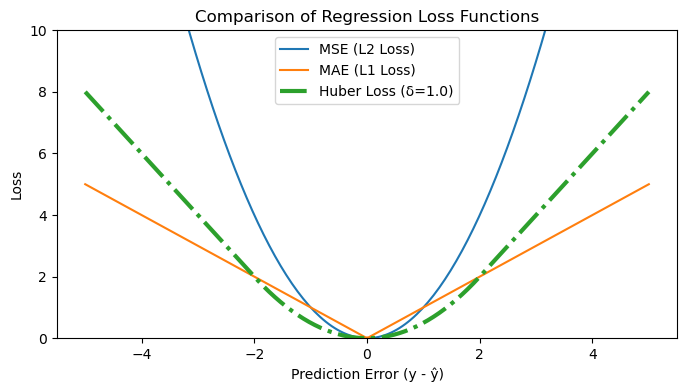

In [15]:
def huber_loss(error, delta=1.0):
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * error**2
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.where(is_small_error, squared_loss, linear_loss)

# プロット用のデータ
error = np.linspace(-5, 5, 200)
y_mse = error**2
y_mae = np.abs(error)
y_huber = huber_loss(error, delta=2.0)

# グラフ描画
plt.figure(figsize=(8, 4))
plt.plot(error, y_mse, label="MSE (L2 Loss)")
plt.plot(error, y_mae, label="MAE (L1 Loss)")
plt.plot(error, y_huber, label="Huber Loss (δ=1.0)", linestyle='-.', linewidth=3)
plt.title("Comparison of Regression Loss Functions")
plt.xlabel("Prediction Error (y - ŷ)")
plt.ylabel("Loss")
plt.ylim(0, 10)
plt.legend()
plt.show()

## 5. 考察

このノートブックでは、分類タスクと回帰タスクにおける主要な損失関数について学びました。

損失関数の選択は、解きたいタスクの性質そのものを定義する行為です。モデルが何を「良い予測」とみなし、何を「悪い予測」とみなすかを決定づけます。適切な損失関数を選ぶことで、モデルは我々が意図した方向へ効率的に学習を進めることができます。